In [1]:
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Reshape, UpSampling2D, Conv2D, Activation, LeakyReLU, Dropout, Flatten

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 생성자 모델 만들기

# 모델 이름을 generate로 정하고 Sequential() 함수를 호출
generator = Sequential() 
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding = "same"))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding="same", activation="tanh"))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [4]:
# 판별자 모델 만들기

# 모델 이름을 discriminator로 정하고 Sequential() 함수 호출
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = "same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [5]:
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = "adam")

In [6]:
discriminator.trainable = False

In [7]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape = (100,))

In [8]:
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)

In [9]:
gan.compile(loss = "binary_crossentropy",
            optimizer = "adam")

In [10]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [11]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")

  # 127.5를 빼준 뒤 127.5로 나눠서 -1 ~ 1 사이의 값으로 변환
  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)

    # 판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print("epoch:%d" % i, " d_loss:%.4f" % d_loss, " g_loss:%.4f" % g_loss)

    # 중간 과정을 이미지로 저장하는 부분, 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gen_images 폴더에 저장하라는 뜻.
    # 이 코드는 본 장의 주된 목표와는 관계가 없어서 코드만 소개한다.

    if i % saving_interval == 0:
      # r, c = 5, 5
      noise = np.random.normal(0, 1, (25, 100))
      gem_imgs = generator.predict(noise)

      # Rescale image 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = "gray")
          axs[j, k].axis("off")
          count += 1
          #fig.savefig("gan_images/gan_mnist_%d.png" % i)

11493376/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0  d_loss:0.7047  g_loss:0.6354
epoch:1  d_loss:0.4939  g_loss:0.3856
epoch:2  d_loss:0.4439  g_loss:0.1154
epoch:3  d_loss:0.6023  g_loss:0.0378
epoch:4  d_loss:0.7349  g_loss:0.0597
epoch:5  d_loss:0.6313  g_loss:0.2125
epoch:6  d_loss:0.4979  g_loss:0.5589
epoch:7  d_loss:0.5169  g_loss:0.8131
epoch:8  d_loss:0.5447  g_loss:0.8249
epoch:9  d_loss:0.5276  g_loss:0.8040
epoch:10  d_loss:0.4303  g_loss:0.7502
epoch:11  d_loss:0.3654  g_loss:0.8437
epoch:12  d_loss:0.3240  g_loss:0.9393
epoch:13  d_loss:0.2448  g_loss:1.2485
epoch:14  d_loss:0.2049  g_loss:1.5091
epoch:15  d_loss:0.2754  g_loss:1.5137
epoch:16  d_loss:0.3916  g_loss:1.3513
epoch:17  d_loss:0.3333  g_loss:1.3441
epoch:18  d_loss:0.4552  g_loss:1.0054
epoch:19  d_loss:0.7431  g_loss:0.9142
epoch:20  d_loss:0.7161  g_loss:1.0545
epoch:21  d_loss:0.8781  g_loss:0.8535
epoch:22  d_loss:0.8710  g_loss:0.6053
epoch:23  d_loss:0.5808  g_loss:0.6927
epoch:24  d_loss:0.4274  g_loss:0.8715
epoch:25  d_loss:0.4321  g_loss:0.7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


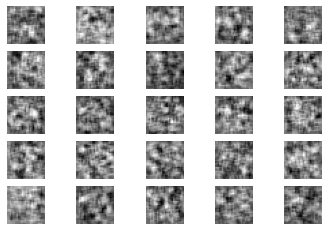

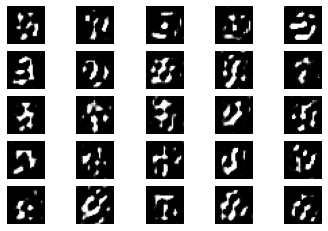

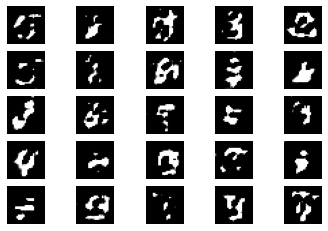

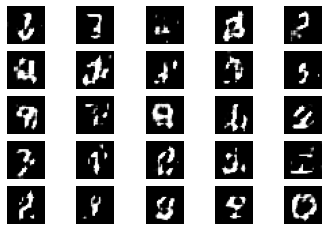

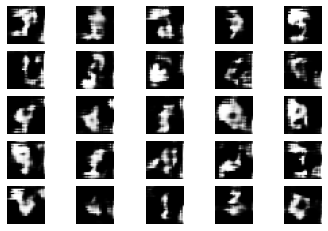

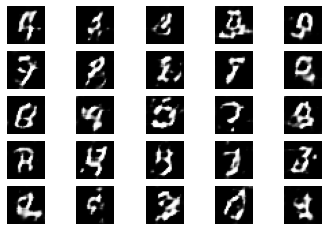

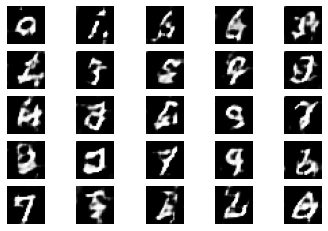

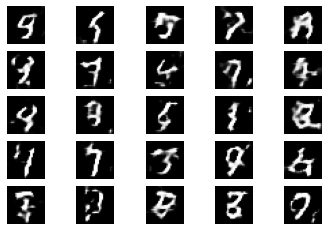

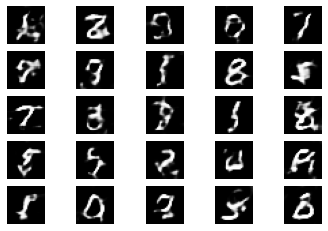

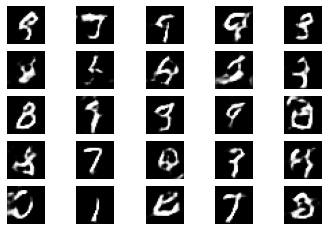

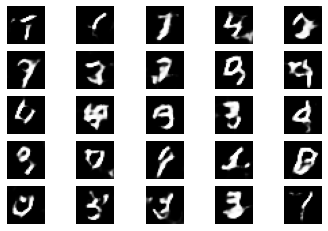

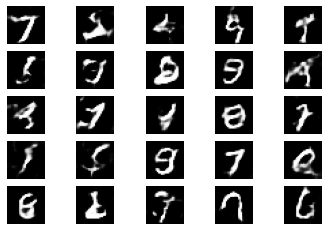

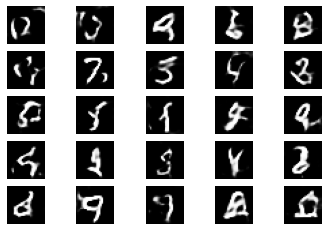

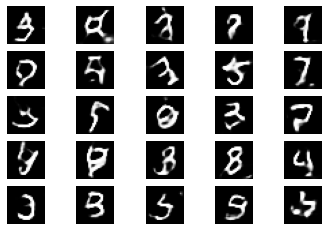

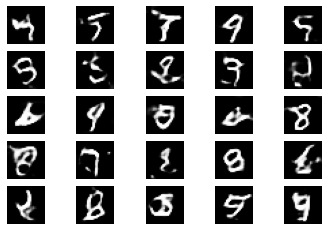

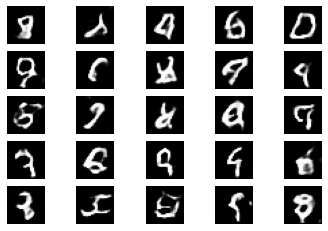

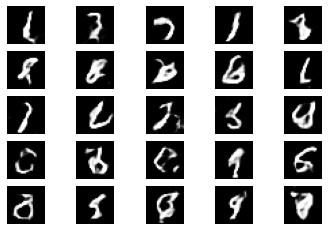

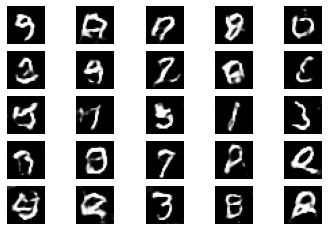

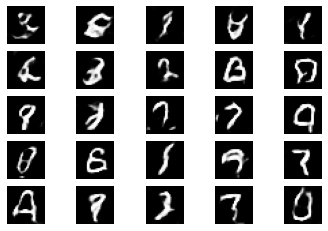

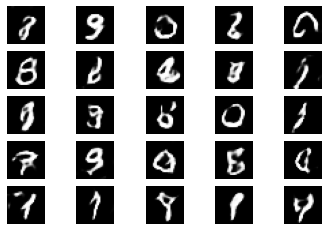

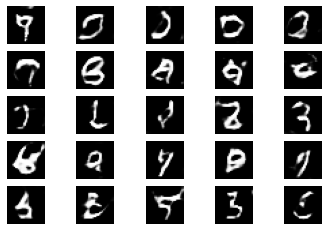

In [12]:
# 4000번 반복되고(+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)

In [12]:
plt.imshow(x_train)